<a href="https://colab.research.google.com/github/thanuja-007/webmining-/blob/main/ANPR_SOFTWARE_PRJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install OpenCV, PyTesseract, and NumPy
!pip install opencv-python pytesseract numpy
# Install Tesseract OCR
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
import cv2
import pytesseract
import numpy as np
from google.colab.patches import cv2_imshow

# Set the path to Tesseract executable (update this path based on your installation)
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:

#import cv2_imshow

# Check OpenCV version
print("OpenCV version:", cv2.__version__)

# Check PyTesseract version
print("PyTesseract version:", pytesseract.get_tesseract_version())

# Check NumPy version
print("NumPy version:", np.__version__)

OpenCV version: 4.11.0
PyTesseract version: 4.1.1
NumPy version: 2.0.2


ANPR CODE


In [ ]:
# Module 1: Image Preprocessing
def preprocess_image(image):
    """
    Preprocess the input image for better number plate detection.
    Steps: Convert to grayscale, enhance contrast, and detect edges.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print("Grayscale Image:")
    cv2_imshow(gray)

    # Apply histogram equalization to enhance contrast
    equalized = cv2.equalizeHist(gray)
    print("Equalized Image:")
    cv2_imshow(equalized)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(equalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 2)  # Increased block size
    print("Thresholded Image:")
    cv2_imshow(thresh)

    # Apply morphological operations to enhance the number plate region
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    print("Dilated Image:")
    cv2_imshow(dilated)

    # Detect edges using Canny edge detection
    edges = cv2.Canny(dilated, 50, 150)  # Adjusted thresholds
    print("Edges Detected:")
    cv2_imshow(edges)

    return edges


MOD 2


In [ ]:
# Module 2: Number Plate Localization
def locate_number_plate(image):
    """
    Locate the number plate region in the image using contour detection.
    """
    # Find contours in the preprocessed image
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # some work to be done here thanuja , see what that is

    # Debug: Print the number of contours found
    print(f"Number of contours found: {len(contours)}")

    # Sort contours by area and select the largest ones
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # Loop through contours to find the best rectangular contour
    number_plate_contour = None
    for contour in contours:
        # Approximate the contour to a polygon
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.018 * perimeter, True)

        # Debug: Print the number of vertices for each contour
        print(f"Contour vertices: {len(approx)}")

        # Relax the condition: Allow contours with 3-5 vertices
        if 3 <= len(approx) <= 5:
            number_plate_contour = approx
            break

    # If no valid contour is found, return None   # y is this fdefaultly coming man ??
    if number_plate_contour is None:
        print("No valid contour found.")
        return None, None

    # Get the bounding box of the number plate
    x, y, w, h = cv2.boundingRect(number_plate_contour)

    # Crop the number plate region
    number_plate = image[y:y+h, x:x+w]
    print("Number Plate Region:")
    cv2_imshow(number_plate)

    return number_plate, (x, y, w, h)

MOD 3


In [ ]:
# Module 3: Character Segmentation
def segment_characters(number_plate):
    """
    Segment individual characters from the number plate.
    """
    # Apply thresholding to isolate characters
    _, binary_plate = cv2.threshold(number_plate, 128, 255, cv2.THRESH_BINARY_INV)
    print("Binary Plate (Inverted Threshold):")
    cv2_imshow(binary_plate)

    # Find contours of individual characters
    contours, _ = cv2.findContours(binary_plate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours from left to right
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    # Extract each character
    characters = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if h > 20 and w > 10:  # Filter out small contours (noise)
            char = number_plate[y:y+h, x:x+w]
            characters.append(char)
            print(f"Character {len(characters)}:")
            cv2_imshow(char)

    return characters   #doesnt return chars !!!!!!!!!!!!!!!!!!!

MOD 4


In [ ]:
# Module 4: Character Recognition

def recognize_characters(characters):
    """
    Recognize characters using PyTesseract OCR.
    """
    recognized_text = ""
    for char in characters:
        # Preprocess character for better OCR accuracy
        char = cv2.resize(char, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        _, char = cv2.threshold(char, 128, 255, cv2.THRESH_BINARY)

        # Use PyTesseract to recognize text
        text = pytesseract.image_to_string(char, config='--psm 10 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
        recognized_text += text.strip()

    return recognized_text

MOD 5 : MAIN FUNCTION


Grayscale Image:


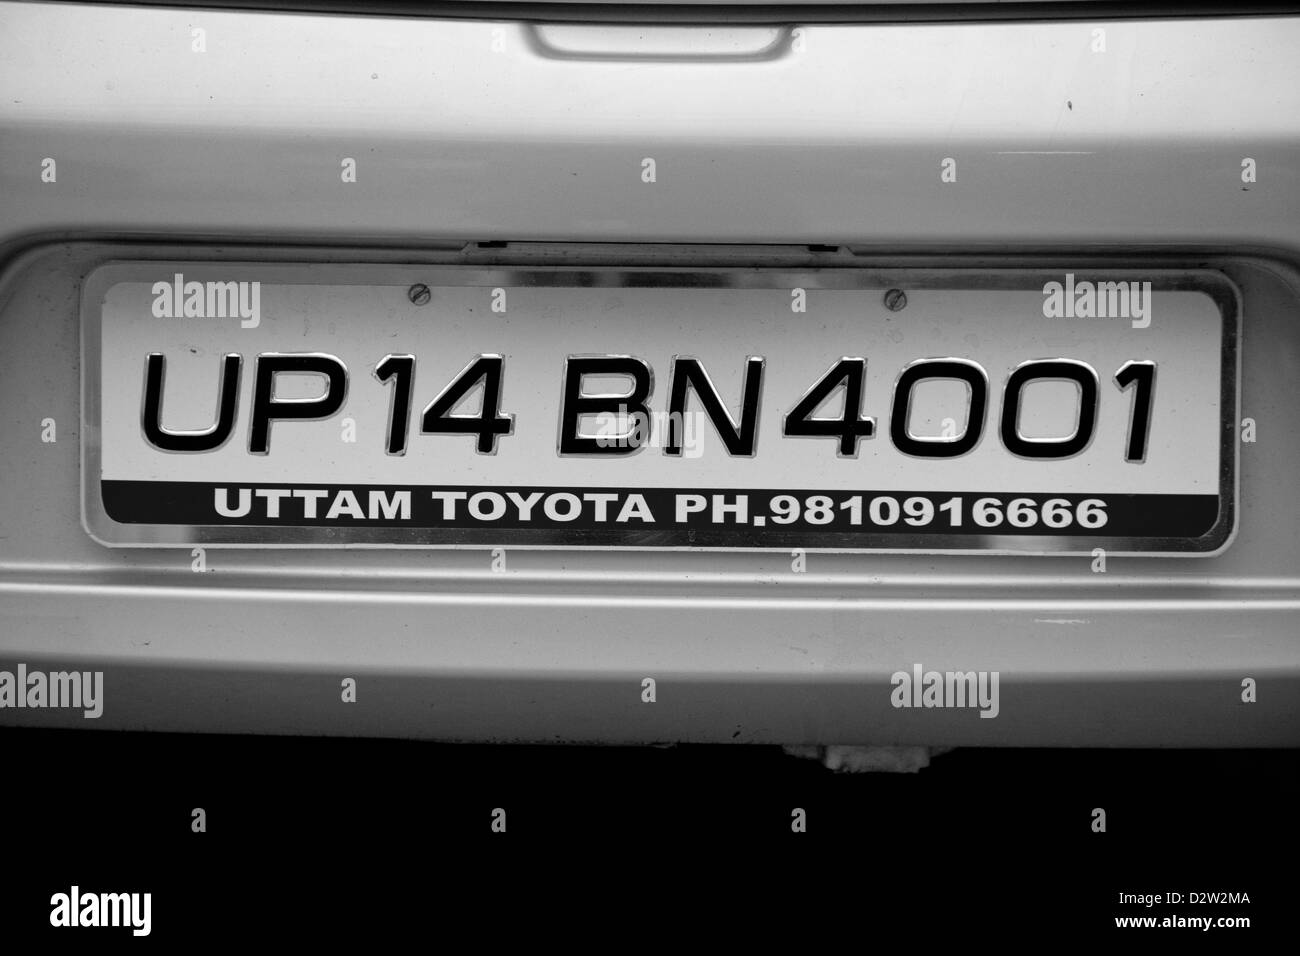

Equalized Image:


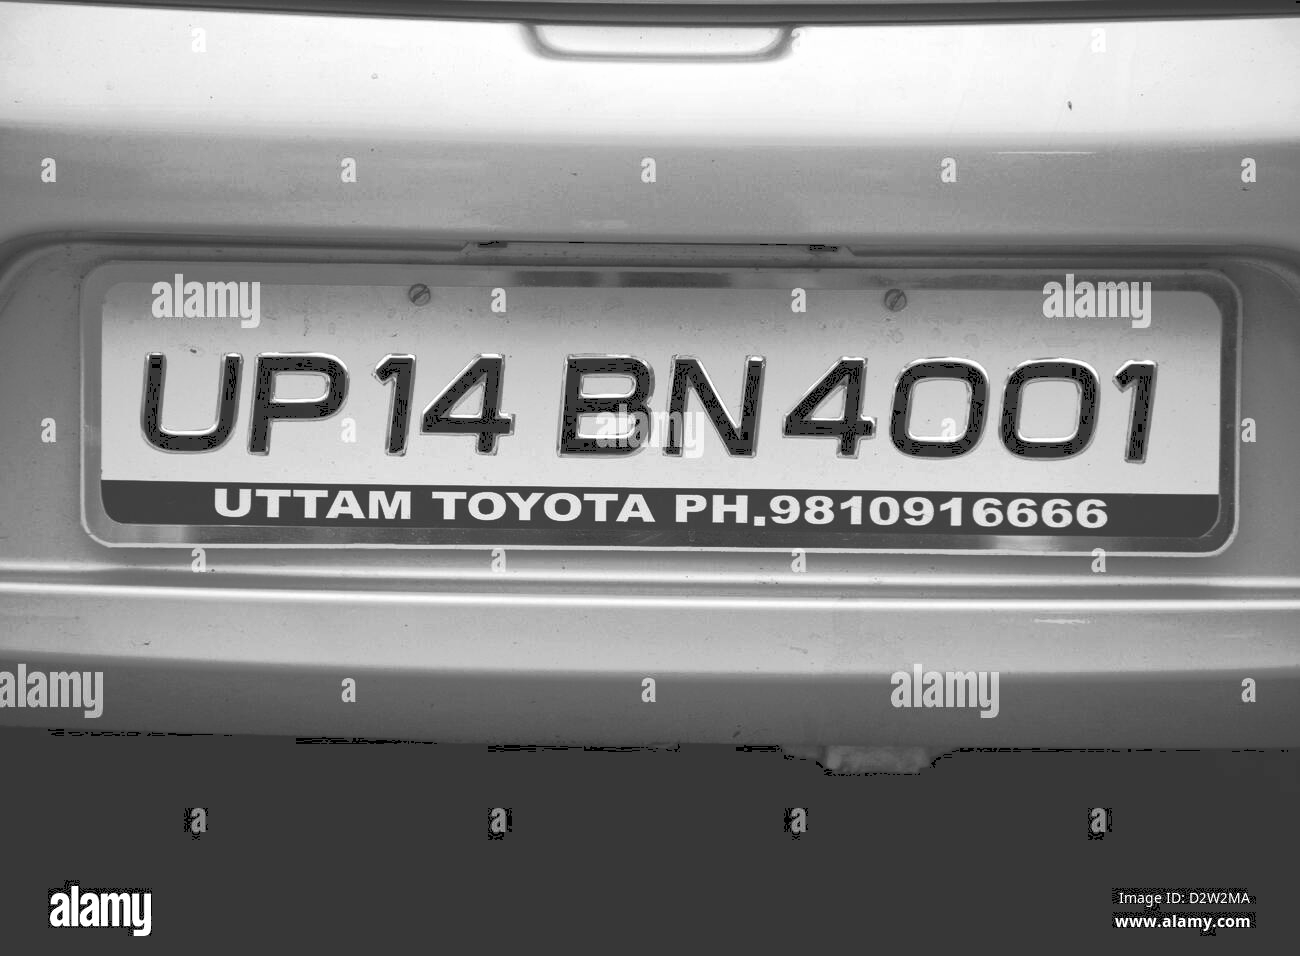

Thresholded Image:


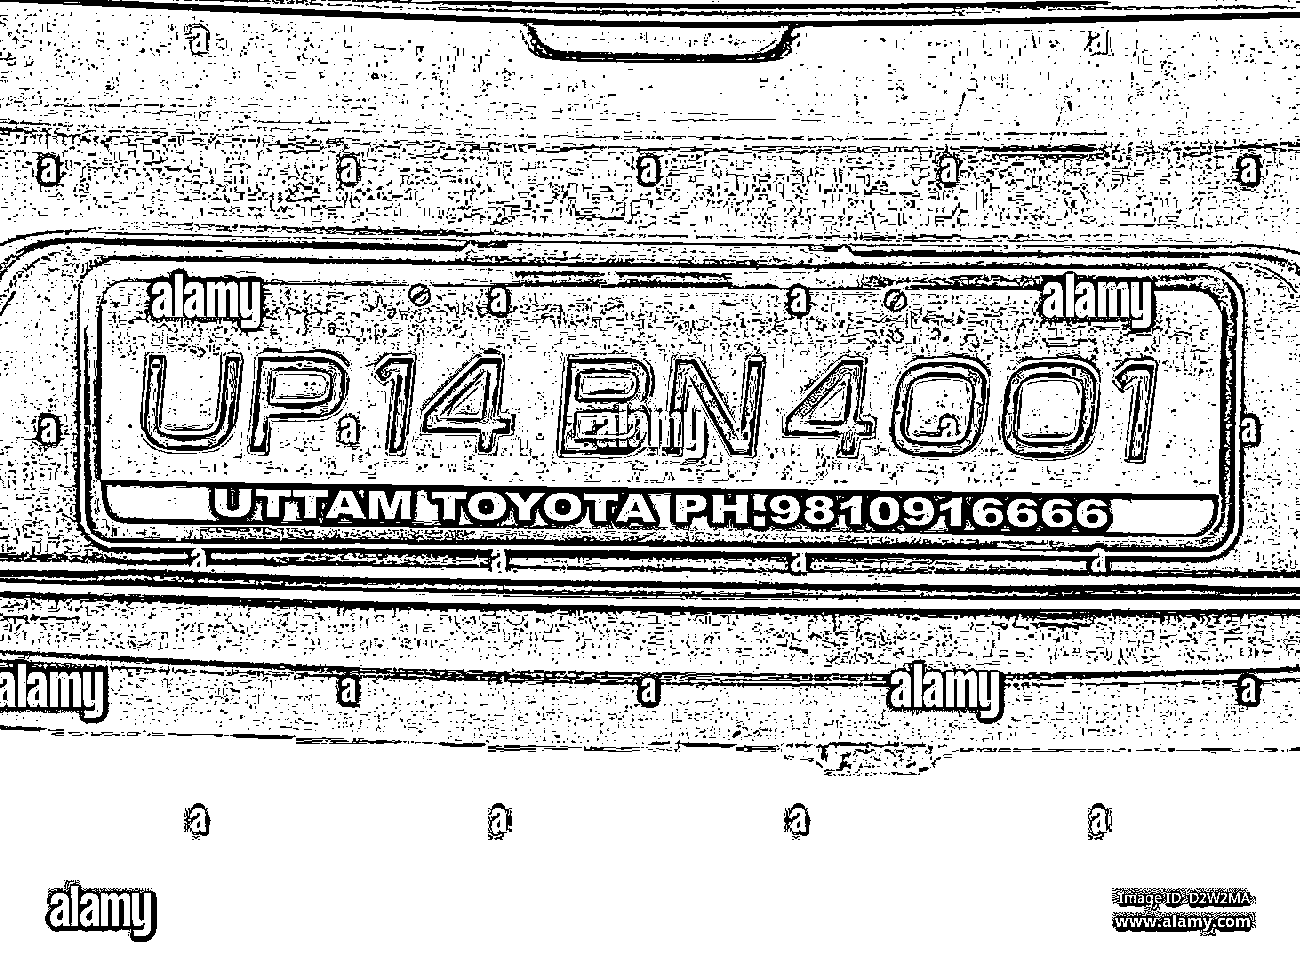

Dilated Image:


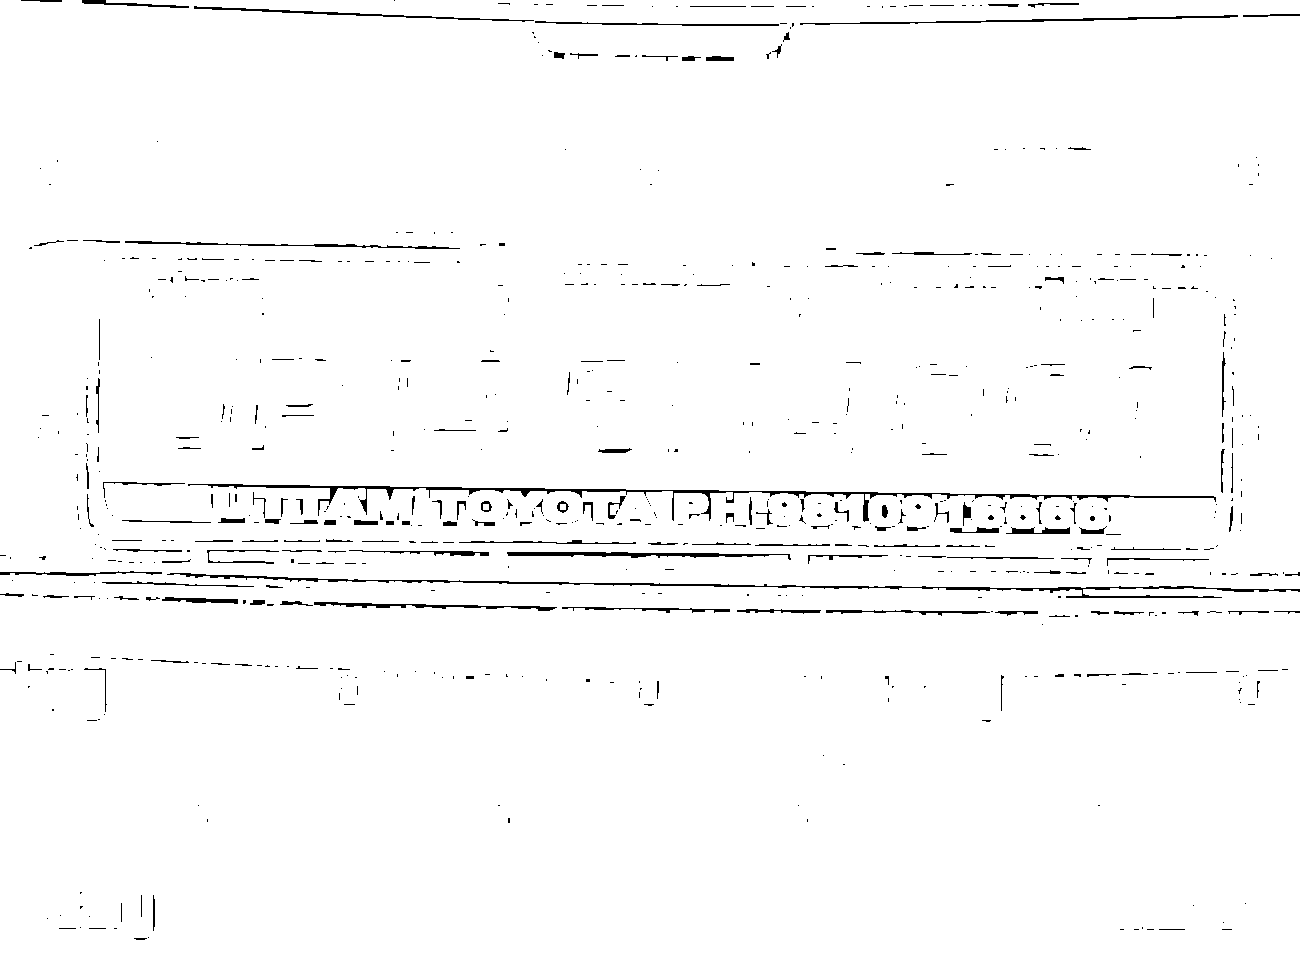

Edges Detected:


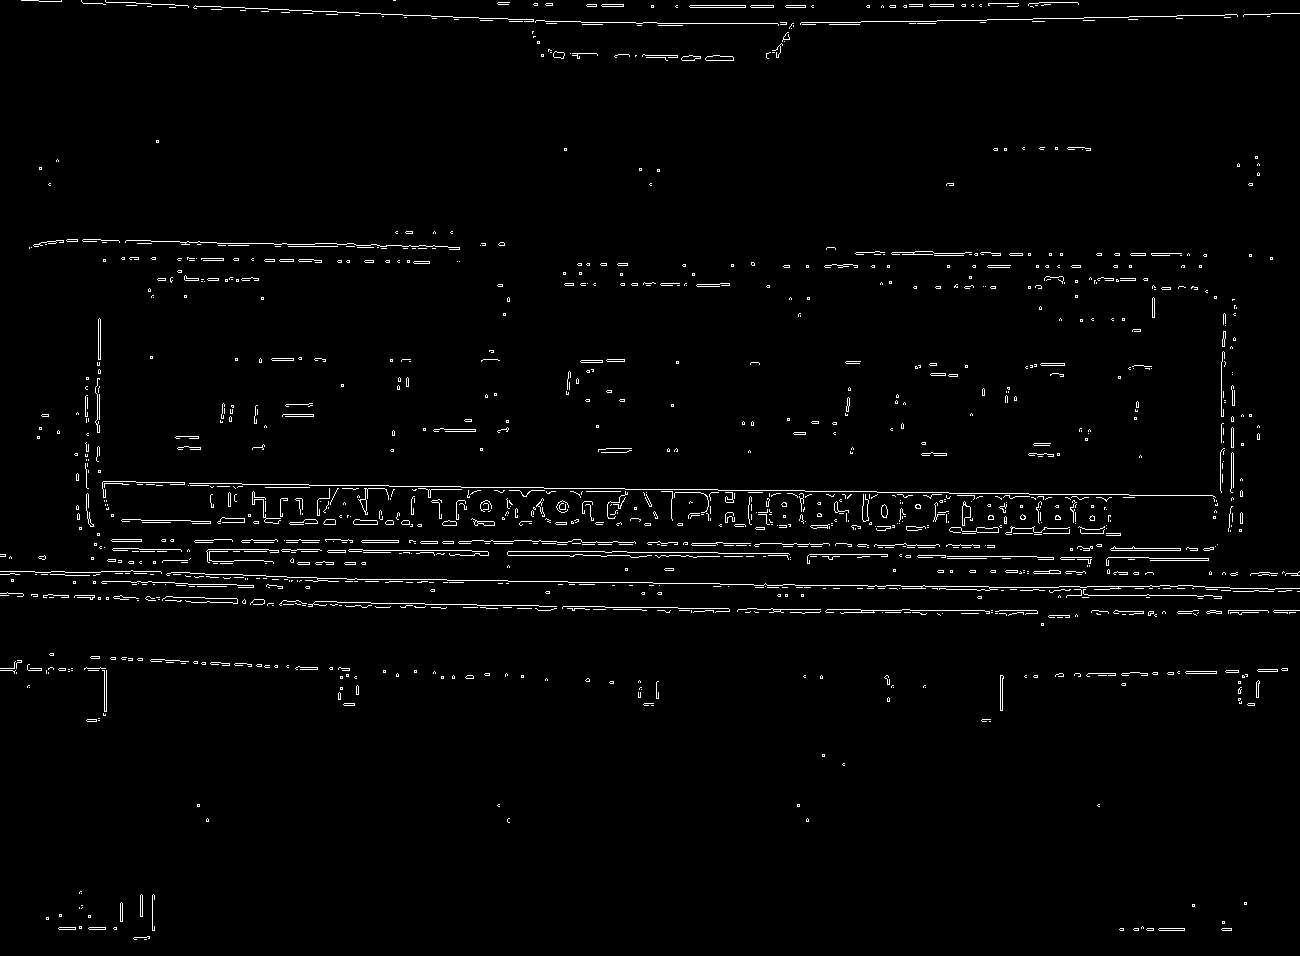

Number of contours found: 1593
Contour vertices: 3
Number Plate Region:


Binary Plate (Inverted Threshold):


No characters detected.


In [ ]:
# Module 5: Main Function
def detect_number_plate(image_path):
    """
    Main function to detect and recognize the number plate from an image.
    """
    # Load the input image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image.")
        return

    # Step 1: Preprocess the image
    edges = preprocess_image(image)

    # Step 2: Locate the number plate
    number_plate, bbox = locate_number_plate(edges)
    if number_plate is None:
        print("No number plate detected.")
        return

    # Step 3: Segment characters from the number plate
    characters = segment_characters(number_plate)
    if not characters:
        print("No characters detected.")
        return

    # Step 4: Recognize characters using OCR
    recognized_text = recognize_characters(characters)

    # Display the results
    print(f"Detected Number Plate: {recognized_text}")

    # Draw bounding box around the number plate
    x, y, w, h = bbox
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Show the output image
    print("Final Output with Detected Number Plate:")
    cv2_imshow(image)


# Run the ANPR System

if __name__ == "__main__":
    # Input image path
    image_path = "/content/no_plate_dfetection2.jpg"
    detect_number_plate(image_path)
